In [ ]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

# Data
from tqdm import tqdm
from glob import glob
import tensorflow.data as tfd

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import applications as tka
!pip install keras_tuner
import keras_tuner as kt
cls()

In [ ]:
#The batch size
BATCH_SIZE = 64

# Image dims
IMAGE_SIZE = (120,120)

# Buffer size
BUFFER = 1000

# Autotuning
AUTOTUNE = tfd.AUTOTUNE

In [ ]:
# Setting the Random Seeds
np.random.seed(1024)
tf.random.set_seed(1024)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path="/content/drive/MyDrive/data2/training_data"
test_path="/content/drive/MyDrive/data2/testing_data"

In [ ]:
# Get the class Names
class_names = sorted(os.listdir(train_path))

# Total number of classes
n_classes = len(class_names)

# Show
print(f"Total Number of Classes : {n_classes}")
print(f"Class Names : \n{class_names}")

Total Number of Classes : 36
Class Names : 
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
def load_image(image_path:str):



    # Load image file
    image_loaded = tf.io.read_file(image_path)

    try:
        # Decode the png image
        image_decoded = tf.image.decode_png(contents=image_loaded, channels=3)

        # Convert the dtype
        image_cnvt = tf.image.convert_image_dtype(image=image_decoded, dtype=tf.float32)

        # Resize the image
        image_resize = tf.image.resize(images=image_cnvt, size=IMAGE_SIZE)

        # Normalize image
        image_norm = tf.clip_by_value(image_resize, clip_value_min=0.0, clip_value_max=1.0)

        # Just for security
        image = tf.cast(x=image_norm, dtype=tf.float32)

        # return
        return image
    except:
        pass

In [ ]:
def load_data(root_path, class_names, trim=None, shuffle=False, split=None):




    # Collect all file paths
    if trim is not None:
        details = [(path, name) for name in class_names for path in glob(pathname=f"{root_path}/{name}/*.png")[:trim]]

    else:
        details = [(path, name) for name in class_names for path in glob(pathname=f"{root_path}/{name}/*.png")]


    # Create space for images and labels
    images = np.empty(shape=(len(details), *IMAGE_SIZE, 3), dtype='float32')
    labels = np.empty(shape=(len(details), 1), dtype='int64')


    # Iterate over all file paths
    for index, (path, name) in tqdm(enumerate(details), desc="Loading"):

        # Load the image
        image = load_image(image_path=path)

        # get the label
        label = class_names.index(name)

        # Store this image and label
        images[index] = image
        labels[index] = label

    # Convert the data into tensorflow data
    data_set = tfd.Dataset.from_tensor_slices((
        images, labels
    ))

    # Shuffle if needed
    if shuffle:
        data_set = data_set.shuffle(BUFFER)

    # Split the data if needed
    if split is not None:

        # get the data sizes
        test_size = int(split * len(images))
        train_size = int(len(images) - test_size)

        # Split the data
        train_set = data_set.take(train_size)
        test_set  = data_set.skip(train_size).take(test_size)

        # Batchify the data
        train_set = train_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        test_set = test_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)

        # Return data
        return train_set, test_set

    else:
        # The whole data
        data_set = data_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)

        # Return complete data
        return data_set

In [ ]:
# Load Training data
train_ds = load_data(root_path=train_path, class_names=class_names, trim=300, shuffle=True)

Loading: 10800it [1:00:05,  3.00it/s]


In [ ]:
# Load Validation data
test_ds, valid_ds = load_data(root_path=test_path, class_names=class_names, shuffle=True, split=0.2)
cls()

In [ ]:
print(f"Training Data Size   : {tf.data.experimental.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.experimental.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.experimental.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 10816
Validation Data Size : 704
Testing Data Size    : 2624


In [ ]:
def show_images(data, GRID=[8,8], FIGSIZE=(20,20), model=None):


    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_images = GRID[0] * GRID[-1]

    # Get the data for data visualization
    images, labels = next(iter(data))

    # Iterate over data
    for n_image, (image, label) in enumerate(zip(images, labels)):

        # Plot the image into the subplot.
        plt.subplot(GRID[0], GRID[1], n_image+1)
        plt.imshow(tf.squeeze(image))
        plt.axis('off')

        # Adding the title
        if model is not None:
            image = tf.expand_dims(image, axis=0)
            pred = model.predict(image)[0]
            max_index = tf.argmax(pred)
            score = pred[max_index]
            pred_label = class_names[max_index]
            title = "Pred : {}\nScore : {:.4}".format(pred_label, score)
            plt.title(title)

        # Break the loop
        if n_image+1>=n_images:
            break

    # Show the final plot
    plt.tight_layout()
    plt.show()

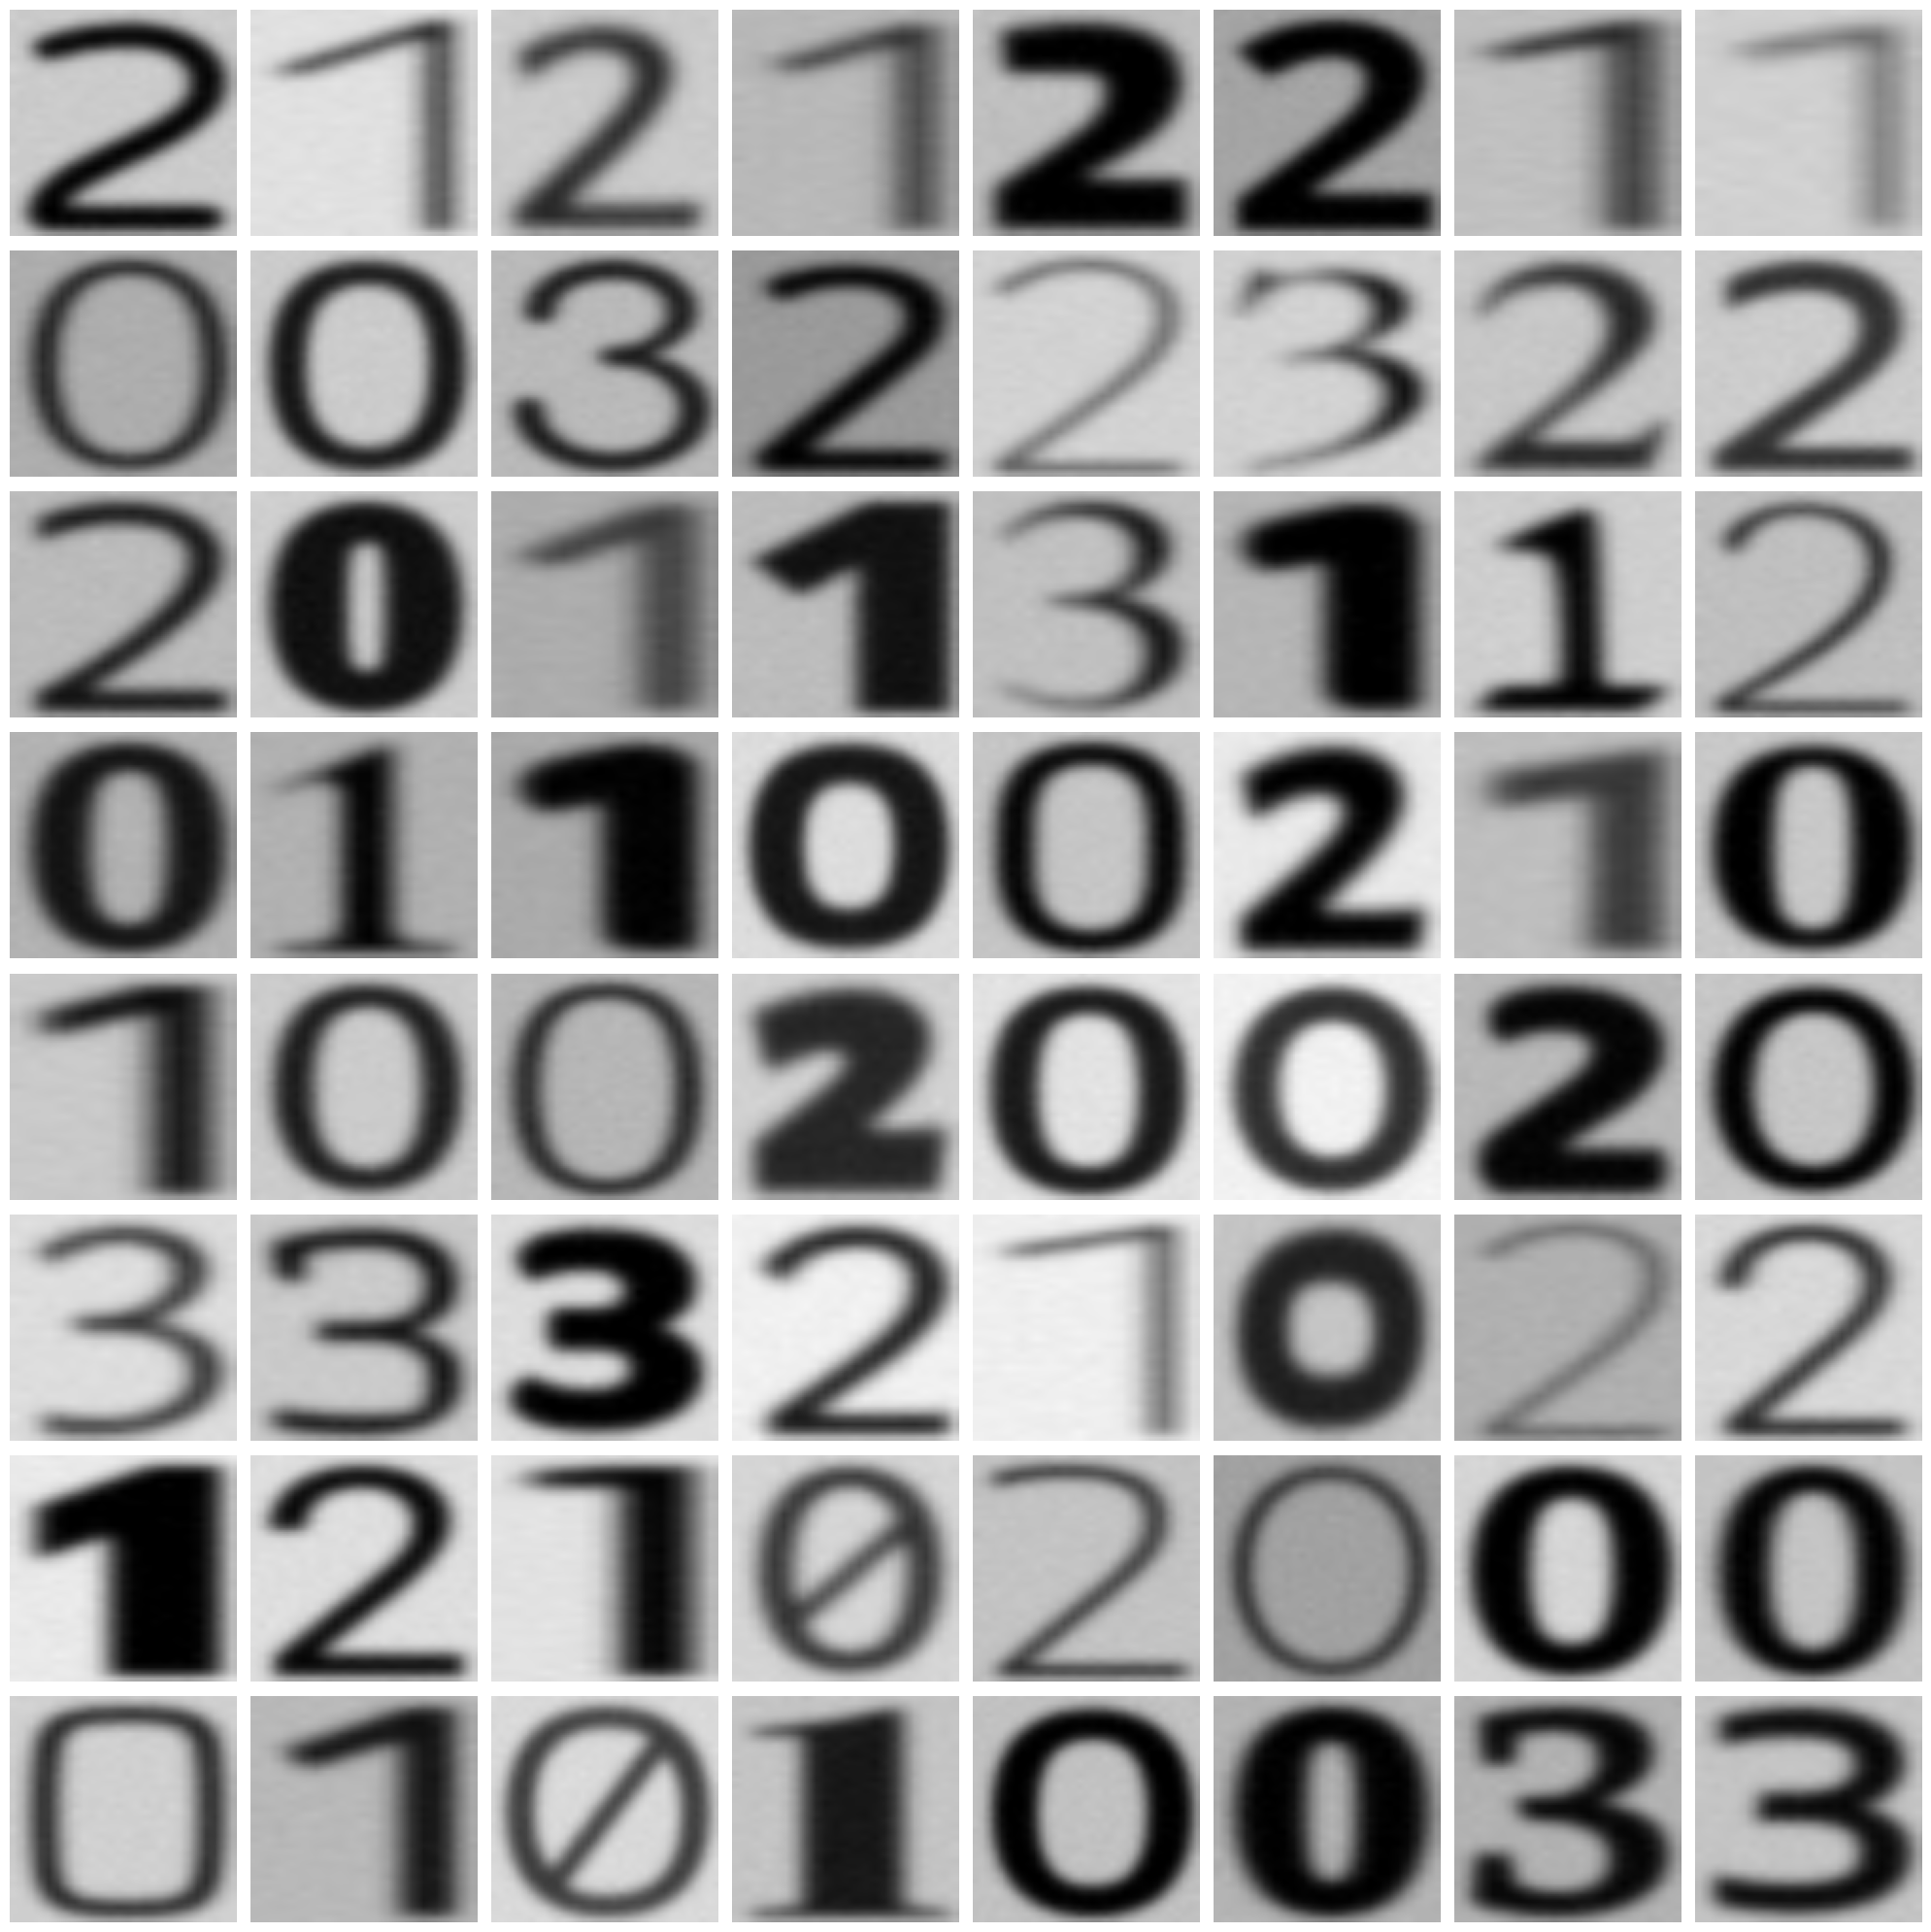

In [ ]:
show_images(data=train_ds)

In [ ]:
# All the backbones will be accessed through a name.
BACKBONE_NAMES = [
    'ResNet50',
   'ResNet50V2',
    'ResNet152V2',
    'Inception',
    'Xception',
    'MobileNet'
    'EfficientNetB3'
]

In [ ]:
# Load the backbones
BACKBONES = [
   tka.ResNet50(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
   tka.ResNet50V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
   tka.ResNet152V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
   tka.InceptionV3(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.Xception(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
   tka.MobileNet(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.EfficientNetB3(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
]

for backbone in BACKBONES:
    backbone.trainable = False

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
# store the Backbone histories.
BACKBONE_HISTORIES = []

# Iterate over the backbones
for name, backbone in zip(BACKBONE_NAMES, BACKBONES):

    # Show
    print(f'BACKBONE : {name.title()}\n')

    # Create a simple model architecture.
    dummy_model = keras.Sequential(layers=[
        layers.InputLayer(input_shape=(*IMAGE_SIZE, 3), name="InputLayer"),
        backbone,
        layers.GlobalAveragePooling2D(name="GAP"),
        layers.Dropout(0.2, name="DropoutLayer"),
        layers.Dense(len(class_names), activation='softmax', name="OutputLayer")
    ], name=name.strip().title())

    # Show the summary
    print('-'*100)
    print("Model Summary\n")
    dummy_model.summary()
    print("\n")
    print('-'*100)

    # Compile the model.
    dummy_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    # Train the model
    print("\n")
    print('-'*100)
    print("Model Training\n")
    history = dummy_model.fit(train_ds, validation_data=test_ds, epochs=15)
    print("\n")
    print('-'*100)

    # Store the history
    BACKBONE_HISTORIES.append(
        pd.DataFrame(history.history)
    )

    # clear the output.
   # cls()

BACKBONE : Resnet50V2

----------------------------------------------------------------------------------------------------
Model Summary

Model: "Resnet50V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 GAP (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 DropoutLayer (Dropout)      (None, 2048)              0         
                                                                 
 OutputLayer (Dense)         (None, 36)                73764     
                                                                 
Total params: 58,405,412
Trainable params: 73,764
Non-trainable params: 58,331,648
________________________________

In [ ]:
# Plotting configurations
plt.figure(figsize=(25, 35))

# Iterate over the backbone histories.
index = 1
for name, history in zip(BACKBONE_NAMES, BACKBONE_HISTORIES):

    # subplot of the Backbone Learning curve.
    plt.subplot(6, 2, index)
    plt.title(name.strip().title() + " - Loss Curve", fontsize=15)
    plt.plot(history['loss'], label="Training Loss")
    plt.plot(history['val_loss'], label="Validation Loss")
    plt.ylabel("Loss")
    plt.legend(fontsize=15)
    plt.grid()

    plt.subplot(6, 2, index+1)
    plt.title(name.strip().title() + " - Accuracy Curve", fontsize=15)
    plt.plot(history['accuracy'], label="Training Accuracy")
    plt.plot(history['val_accuracy'], label="Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.legend(fontsize=15)
    plt.grid()

    # update index
    index+=2

# show the final plot.
plt.savefig("BackboneComparision-All.png")
plt.show()

In [ ]:
# Name of the top 3 backbones.
TOP_3_BACKBONES = ['ResNet152V2', 'Inception','Xception']

# Plotting configurations
plt.figure(figsize=(20, 25))

# Iterate over the backbone histories.
index = 1
for name, history in zip(BACKBONE_NAMES, BACKBONE_HISTORIES):

    if name in TOP_3_BACKBONES:
        # subplot of the Backbone Learning curve.
        plt.subplot(6, 2, index)
        plt.title(name.strip().title() + " - Loss Curve", fontsize=15)
        plt.plot(history['loss'], label="Training Loss")
        plt.plot(history['val_loss'], label="Validation Loss")
        plt.ylabel("Loss")
        plt.legend(fontsize=15)
        plt.grid()

        plt.subplot(6, 2, index+1)
        plt.title(name.strip().title() + " - Accuracy Curve", fontsize=15)
        plt.plot(history['accuracy'], label="Training Accuracy")
        plt.plot(history['val_accuracy'], label="Validation Accuracy")
        plt.ylabel("Accuracy")
        plt.legend(fontsize=15)
        plt.grid()

        # update index
        index+=2

# show the final plot.
plt.savefig("BackboneComparision-Top3.png")
plt.show()

In [ ]:
# Name of the top 3 backbones.
TOP_3_BACKBONES = ['ResNet152V2', 'Inception','Xception']

# Plotting configurations
plt.figure(figsize=(20, 25))

# Iterate over the backbone histories.
index = 1
for name, history in zip(BACKBONE_NAMES, BACKBONE_HISTORIES):

    if name in TOP_3_BACKBONES:
        # subplot of the Backbone Learning curve.
        plt.subplot(6, 2, index)
        plt.title(name.strip().title() + " - Loss Curve", fontsize=15)
        plt.plot(history['loss'], label="Training Loss")
        plt.plot(history['val_loss'], label="Validation Loss")
        plt.ylabel("Loss")
        plt.legend(fontsize=15)
        plt.grid()
        plt.ylim(bottom=-0.2, top=1)

        plt.subplot(6, 2, index+1)
        plt.title(name.strip().title() + " - Accuracy Curve", fontsize=15)
        plt.plot(history['accuracy'], label="Training Accuracy")
        plt.plot(history['val_accuracy'], label="Validation Accuracy")
        plt.ylabel("Accuracy")
        plt.legend(fontsize=15)
        plt.grid()
        plt.ylim(bottom=0.8, top=1)

        # update index
        index+=2

# show the final plot.
plt.savefig("BackboneComparision-Top3-CloseLook.png")
plt.show()

In [ ]:
# Name of the top 3 backbones.
TOP_3_BACKBONES = ['ResNet152V2','Xception']

# Plotting configurations
plt.figure(figsize=(20, 30))

# Iterate over the backbone histories.
index = 1
for name, history in zip(BACKBONE_NAMES, BACKBONE_HISTORIES):

    if name in TOP_3_BACKBONES:
        # subplot of the Backbone Learning curve.
        plt.subplot(6, 2, index)
        plt.title(name.strip().title() + " - Loss Curve", fontsize=15)
        plt.plot(history['loss'], label="Training Loss")
        plt.plot(history['val_loss'], label="Validation Loss")
        plt.axhline(y=min(history['loss']), label="Min T.L", color='g', linestyle='--')
        plt.axhline(y=min(history['val_loss']), label="Min V.L", color='r', linestyle='--')
        plt.ylabel("Loss")
        plt.legend(fontsize=15)
        plt.grid()
        plt.ylim(bottom=-0.2, top=1)

        plt.subplot(6, 2, index+1)
        plt.title(name.strip().title() + " - Accuracy Curve", fontsize=15)
        plt.plot(history['accuracy'], label="Training Accuracy")
        plt.plot(history['val_accuracy'], label="Validation Accuracy")
        plt.axhline(y=max(history['accuracy']), label="Max T.A", color='g', linestyle='--')
        plt.axhline(y=max(history['val_accuracy']), label="Max V.A", color='r', linestyle='--')
        plt.ylabel("Accuracy")
        plt.legend(fontsize=15)
        plt.grid()
        plt.ylim(bottom=0.8, top=1)

        # update index
        index+=2

# show the final plot.
plt.savefig("BackboneComparision-Top2-CloseLook.png")
plt.show()

In [ ]:
# Using the best validation accuracy as baseline accuracy.
BASELINE_ACC = max(BACKBONE_HISTORIES[BACKBONE_NAMES.index('EfficientNetB3')]['val_accuracy'])

# Similarly, using the best validation loss as the baseline loss.
#BASELINE_LOSS = min(BACKBONE_HISTORIES[BACKBONE_NAMES.index('ResNet50V2')]['val_loss'])

BASELINE_LOSS = min(BACKBONE_HISTORIES[BACKBONE_NAMES.index('EfficientNetB3')]['val_loss'])


print('--'*50)
print(" "*25 + f"Best Loss : {np.round(BASELINE_LOSS, decimals=4)}; Best Accuracy : {np.round(BASELINE_ACC, decimals=3)*100}%")
print('--'*50)

In [ ]:
def build_model(hp):

    # Backbone
    backbone = tka.ResNet50V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
    backbone.trainable = False

    # Base Model
    model = keras.Sequential(layers=[
        layers.InputLayer(input_shape=(*IMAGE_SIZE, 3), name="InputLayer"),
        backbone,                                                            # ResNet50V2
        layers.GlobalAveragePooling2D(name="GAP"),
    ], name=name.strip().title())

    # Params to tweak
    for i in range(hp.Choice('n_layers', [1,2,4])):
        model.add(layers.Dense(hp.Choice('n_units', [64, 256])))
    model.add(layers.Dropout(hp.Choice('rate', [0.2,0.4])))

    # Output layer
    model.add(layers.Dense(len(class_names), activation='softmax'))

    # Compile the model.
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    return model

In [ ]:
# Initialize tuner
tuner = kt.RandomSearch(hypermodel=build_model, objective='val_loss', project_name='ResNet50V2-OCR-3')

# Start hyperparameter search.
tuner.search(
    train_ds,
    validation_data=valid_ds,
    epochs = 5
)

In [ ]:
# Get the best model and build it
best_model = tuner.get_best_models()[0]
best_model.build(input_shape=(*IMAGE_SIZE, 3))

In [ ]:
# Training the model
best_model_history = best_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    callbacks = [
        callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        callbacks.ModelCheckpoint('StandardOCR-ResNet50V2.h5', save_best_only=True)
    ]
)

In [ ]:
# Valid Data
best_model.evaluate(valid_ds)

In [ ]:
# Test data
best_model.evaluate(test_ds)

In [ ]:
# Backbone
backbone = tka.ResNet50V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
backbone.trainable = True

# Base Model
model = keras.Sequential(layers=[
    layers.InputLayer(input_shape=(*IMAGE_SIZE, 3), name="InputLayer"),
    backbone,                                                            # ResNet50V2
    layers.GlobalAveragePooling2D(name="GAP"),
    layers.Dense(64),
    layers.Dense(64),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model.
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# History
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=100,
    callbacks = [
        callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        callbacks.ModelCheckpoint('StandardOCR-ResNet50V2-2.h5', save_best_only=True)
    ]
)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=15)
plt.legend(fontsize=15)
plt.ylim([0,1.5])
plt.ylabel('Score')
plt.xlabel('Epochs')
plt.grid()
plt.show()

In [ ]:
model.evaluate(test_ds)